In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [2]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage
from pprint import pprint

In [3]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))


# data_sub_path = 'T12H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01'
# data_sub_path = 'T1H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X255M-Y220M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2015-01-01'
data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2017-01-01'
# data_sub_path = 'T24H-X85M-Y110M_2013-01-01_2015-01-01'
# data_sub_path = 'T3H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T6H-X850M-Y880M_2013-01-01_2015-01-01

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')


In [4]:
conf = BaseConf()
conf.use_crime_types = True

conf.model_name = "LR (CMP+HistAvg)"
# conf.model_name = "LR (CMP)"
# conf.model_name = "LR (TMP)"
# conf.model_name = "LR (SPC)" # demog
# conf.model_name = "LR (ENV)"  # google street view

if conf.use_crime_types:
    conf.model_name = f"{conf.model_name} (crime-types)"
    

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

2019-11-15T22:50:05 | root | INFO | Device: cpu


In [5]:
flat_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
flat_loaders = FlatDataLoaders(data_group=flat_group, conf=conf)


cell_group = CellDataGroup(data_path=conf.data_path, conf=conf)
cell_loaders = CellDataLoaders(data_group=flat_group, conf=conf)


# grid_group = GridDataGroup(data_path=conf.data_path, conf=conf)
# grid_loaders = GridDataLoaders(data_group=grid_group, conf=conf)

2019-11-15T22:50:07 | root | INFO | 	t_range shape (1462,)
finding best max_steps parameter...
best max_steps -> 9
fitted historic average: step (1) and max_steps (9)
2019-11-15T22:50:09 | root | INFO | 	t_range shape (1462,)
finding best max_steps parameter...
best max_steps -> 9
fitted historic average: step (1) and max_steps (9)


In [42]:
results = np.zeros(flat_group.testing_set.target_shape)
tst_len = len(results)
for result_indices, spc_feats, tmp_feats, env_feats, targets in flat_loaders.test_loader:
    for i in range(len(targets)):
        results[result_indices[i]] = targets[0,i,0]
y_true = flat_group.testing_set.targets[-tst_len:]
y_pred = results

pshape(y_true,y_pred)

(99, 1, 704)
(99, 1, 704)


In [44]:
np.sum(y_true-y_pred)

30473.0

In [16]:
flat_group.shaper.h

47

In [5]:
# nn.ModuleDict
# nn.ModuleLinear

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()

        self.name = "LogReg"
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)

        return out  
    
class LogisticRegression3(nn.Module):
    def __init__(self, spc_size, tmp_size, env_size, output_size):
        super(LogisticRegression3, self).__init__()

        self.name = "LogReg3"
        self.lin_spc = nn.Linear(spc_size, output_size)
        self.lin_tmp = nn.Linear(tmp_size, output_size)
        self.lin_env = nn.Linear(env_size, output_size)    
        self.lin_all = nn.Linear(3*output_size, output_size)

        
    def forward(self, spc_feats,tmp_feats,env_feats):        
        out_cat = torch.cat([self.lin_spc(spc_feats),
                             self.lin_tmp(tmp_feats),
                             self.lin_env(env_feats)], dim=-1)
        out_all = self.lin_all(out_cat)
        

        return out_all      

In [7]:
# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = False
conf.max_epochs = 10
conf.dropout = 0#0.2
conf.weight_decay = 1e-4
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-2
conf.batch_size = 32

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set =  1 # 0 #
conf.sub_sample_validation_set = 1 # 0 #

data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

loss_function = nn.CrossEntropyLoss()  

train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

model = LogisticRegression(input_size=spc_size+tmp_size+env_size,
                           output_size=2)

# model = LogisticRegression3(spc_size=spc_size,
#                             tmp_size=tmp_size,
#                             env_size=env_size,
#                             output_size=2)

model.to(conf.device)

parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

2019-11-15T21:47:34 | root | INFO | 	t_range shape (731,)
finding best max_steps parameter...
best max_steps -> 8
fitted historic average: step (1) and max_steps (8)


In [50]:
def train_log_reg(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    epoch_losses = []
    num_batches = batch_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
        current_batch = batch_loader.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        cmp_feats = torch.Tensor(np.concatenate((spc_feats[0], tmp_feats[0], env_feats[0]),axis=-1)).to(conf.device)
        spc_feats = torch.Tensor(spc_feats[0]).to(conf.device)  # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device)  # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(conf.device)  # only taking [0] for fnn
        targets = torch.LongTensor(targets[0, :, 0]).to(conf.device)  # only taking [0] for fnn

        out = model(cmp_feats)
#         out = model(spc_feats)
#         out = model(tmp_feats)
#         out = model(env_feats)
#         out = model(spc_feats=spc_feats,
#                     tmp_feats=tmp_feats,
#                     env_feats=env_feats)
        
        loss = loss_fn(input=out, target=targets)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])

        if model.training:  # not used in validation loops
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    return mean_epoch_loss


def evaluate_log_reg(model, batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(np.concatenate((spc_feats[0], tmp_feats[0], env_feats[0]),axis=-1)).to(conf.device)
            spc_feats = torch.Tensor(spc_feats[0]).to(conf.device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(conf.device)  # only taking [0] for fnn
#             targets = torch.LongTensor(targets[0, :, 0]).to(conf.device)  # only taking [0] for fnn


            out = model(cmp_feats)
#             out = model(tmp_feats)
#             out = model(env_feats)
#             out = model(spc_feats=spc_feats,
#                         tmp_feats=tmp_feats,
#                         env_feats=env_feats)
            

            batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction

            for i, p in zip(indices, batch_probas_pred):
                n, c, l = i
                probas_pred[n, c, l] = p

    return y_true, probas_pred, t_range

## Training

2019-11-15T11:16:17 | root | INFO | 
 ====================== Training LR (CMP+HistAvg) (crime-types) ====================== 

2019-11-15T11:16:17 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 32,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.01,
 'max_epochs': 10,
 'model_name': 'LR (CMP+HistAvg) (crime-types)',
 'model_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/LR '
               '(CMP+HistAvg) (crime-types)/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample_validation_set': 1,
 'timer': <utils.utils.Timer obj

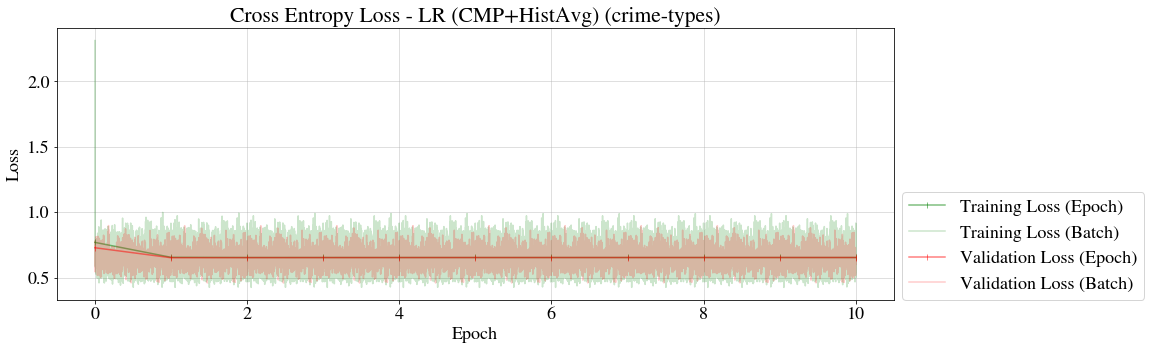

In [51]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                 optimiser=optimiser,
                                                                 loaders=loaders,
                                                                 train_epoch_fn=train_log_reg,
                                                                 loss_fn=loss_function,
                                                                 conf=conf)    

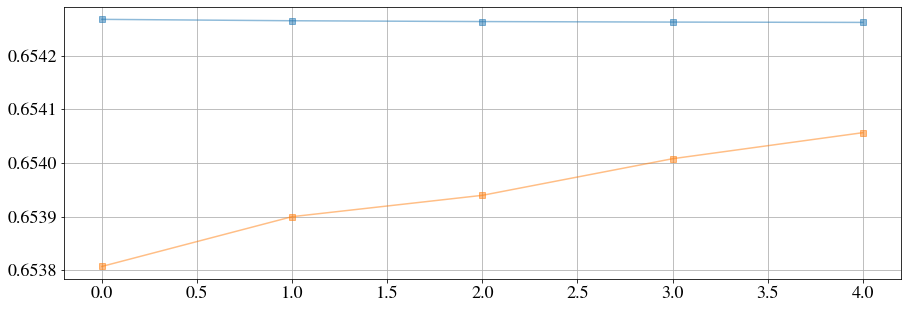

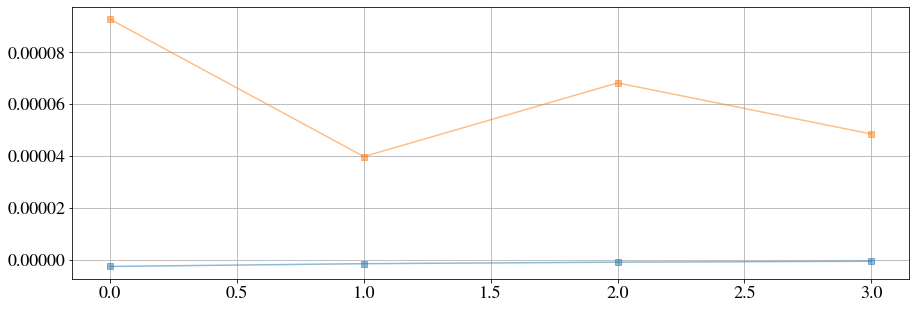

In [52]:
plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[-5:],marker='s',alpha=.5)
plt.grid(True)    
plt.show()

plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(np.diff(x[-5:]),marker='s',alpha=.5)
plt.grid(True)    
plt.show()

## Evaluation

In [53]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-11-15T11:21:12 | root | INFO | Loading model from checkpoint (best) for evaluation


<All keys matched successfully>

In [54]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [55]:
# todo set the train_loader to eval so that it does not subsample
trn_y_true, trn_probas_pred, trn_t_range = evaluate_log_reg(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

thresh = best_threshold(y_true=trn_y_true,
                        probas_pred=trn_probas_pred)

# thresholds = best_thresholds(y_true=trn_y_true,
#                              probas_pred=trn_probas_pred)


tst_y_true, tst_probas_pred, tst_t_range = evaluate_log_reg(model=model,
                                                                batch_loader=loaders.test_loader,
                                                                conf=conf)    



tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
# tst_y_pred = get_y_pred_by_thresholds(thresholds, tst_probas_pred)    

2019-11-15T11:21:26 | root | INFO | f1_score: 0.43206652178021354 at index 285730, new threshold 0.46480920910835266


In [56]:
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper, 
             conf=conf)   

2019-11-15T11:21:33 | root | INFO | 
        MODEL METRICS
            Model Name: LR (CMP+HistAvg) (crime-types)
                ROC AUC:            0.6955681420106222                
                Average Precision:  0.3710719367512076
                Precision:          0.3140568939005638
                Recall:             0.570414504154351
                Accuracy:           0.683842775581906
                MCC:                0.23135404841876966          
        
2019-11-15T11:21:33 | root | INFO | 
        MODEL RESULT
            Model Name: LR (CMP+HistAvg) (crime-types)
                ROC AUC:            0.6955681420106222
                Average Precision:  0.3710719367512076                
                Precision:          0.3140568939005638
                Recall:             0.570414504154351
                Accuracy:           0.683842775581906
                MCC:                0.23135404841876966          
        


2019-11-15T11:21:35 | root | INFO | 
                                 ROC AUC  Avg. Precision  Precision    Recall  \
Model Name                                                                      
Global Average                  0.730295        0.403826   0.331204  0.618894   
Historic Average                0.726273        0.402806   0.332023  0.605628   
Ind-Hawkes Model                0.728235        0.402696   0.330198  0.616031   
ST-RESNET                       0.716061        0.395133   0.293219  0.708497   
ST-RESNET-Extra                 0.714119        0.393814   0.318927  0.633230   
LR (CMP+HistAvg)                0.707614        0.381123   0.321831  0.582796   
LR (CMP+HistAvg) (crime-types)  0.695568        0.371072   0.314057  0.570415   
Hawkes General Model            0.672671        0.343037   0.293676  0.563176   
LR (TMP)                        0.616401        0.295557   0.250374  0.568599   
Previous Time Step              0.569146        0.233949   0.188700  1.0

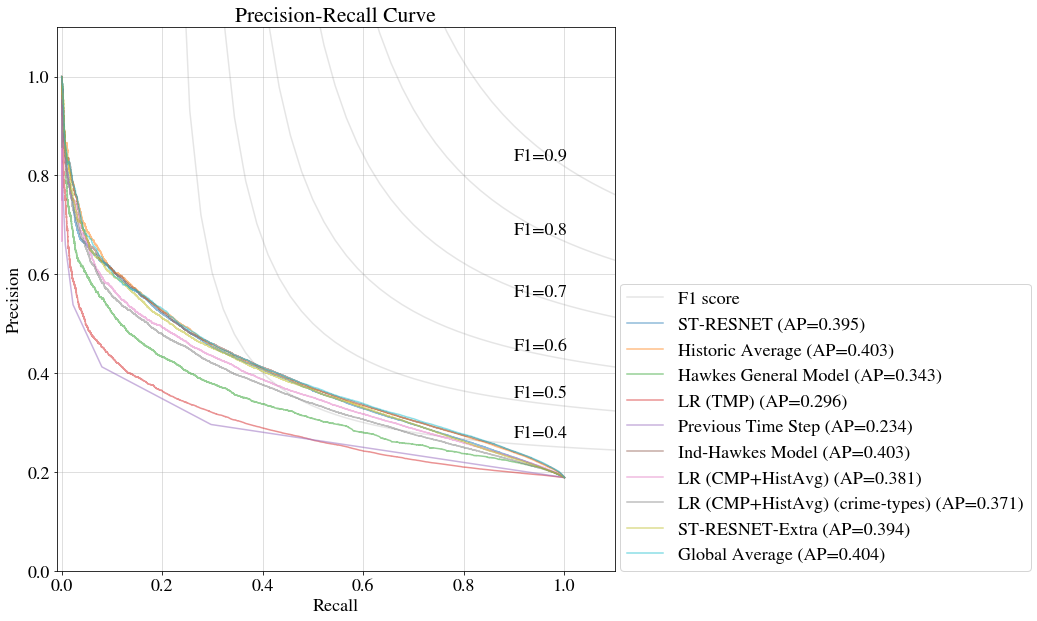

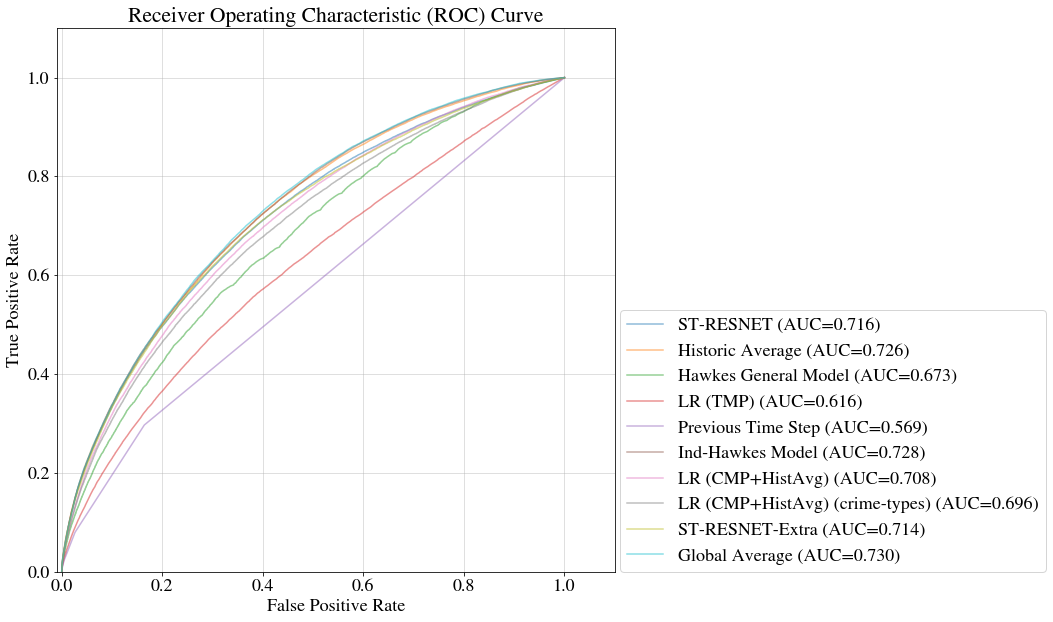

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,
Global Average,0.730295,0.403826,0.331204,0.618894,0.431492,0.692262,0.268789
Historic Average,0.726273,0.402806,0.332023,0.605628,0.428907,0.695665,0.265374
Ind-Hawkes Model,0.728235,0.402696,0.330198,0.616031,0.429943,0.691744,0.266564
ST-RESNET,0.716061,0.395133,0.293219,0.708497,0.414778,0.622736,0.244545
ST-RESNET-Extra,0.714119,0.393814,0.318927,0.633230,0.424204,0.675617,0.257626
LR (CMP+HistAvg),0.707614,0.381123,0.321831,0.582796,0.414672,0.689534,0.245146
LR (CMP+HistAvg) (crime-types),0.695568,0.371072,0.314057,0.570415,0.405084,0.683843,0.231354
Hawkes General Model,0.672671,0.343037,0.293676,0.563176,0.386044,0.661976,0.202037
LR (TMP),0.616401,0.295557,0.250374,0.568599,0.347661,0.597352,0.136498


In [57]:
from utils.metrics import plot_roc_and_pr_curve

compare_models(conf.data_path)

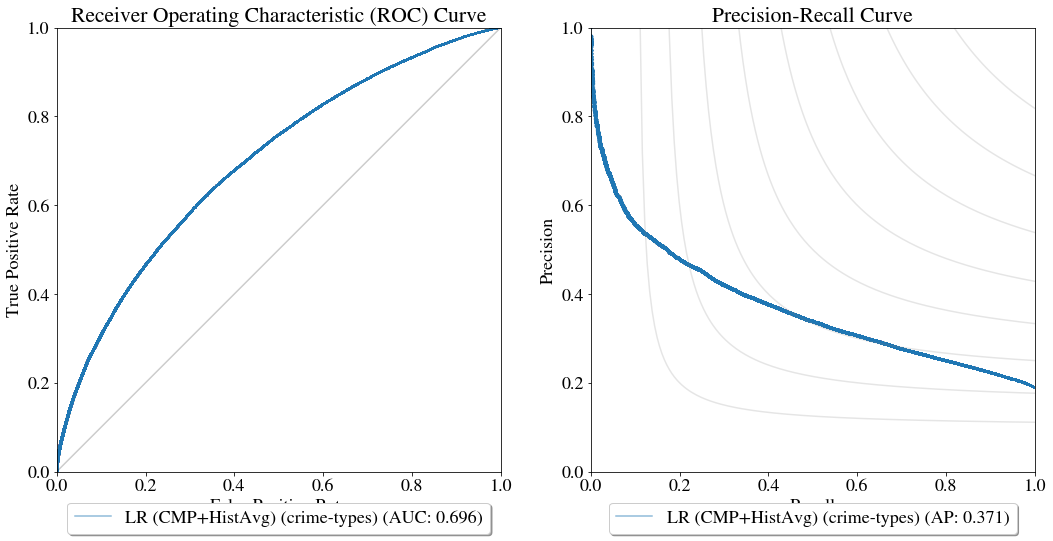

In [58]:
probas_pred_dict = {conf.model_name:tst_probas_pred.flatten()}
plot_roc_and_pr_curve(y_true=tst_y_true.flatten(), probas_pred_dict=probas_pred_dict)

2019-11-13T21:50:49 | root | INFO | 
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.785866        0.746661   0.587615  0.873425  0.702565   
Global Average        0.786672        0.745822   0.591271  0.865153  0.702460   
Ind-Hawkes Model      0.785594        0.744993   0.591839  0.859383  0.700949   
RFNN                  0.784034        0.743637   0.597967  0.848706  0.701607   
ST-RESNET             0.779583        0.738947   0.573003  0.890193  0.697218   
ST-RESNET-Extra       0.769548        0.733298   0.605537  0.823282  0.697818   
LR (CMP)              0.776606        0.728830   0.594392  0.849540  0.699423   
LR (TMP+SPC+ENV)      0.774368        0.727405   0.595878  0.842551  0.698064   
Hawkes General Model  0.764797        0.725320   0.583471  0.837485  0.687774   
Kang FNN              0.763432        0.722039   0.580078  0.847809  0.6

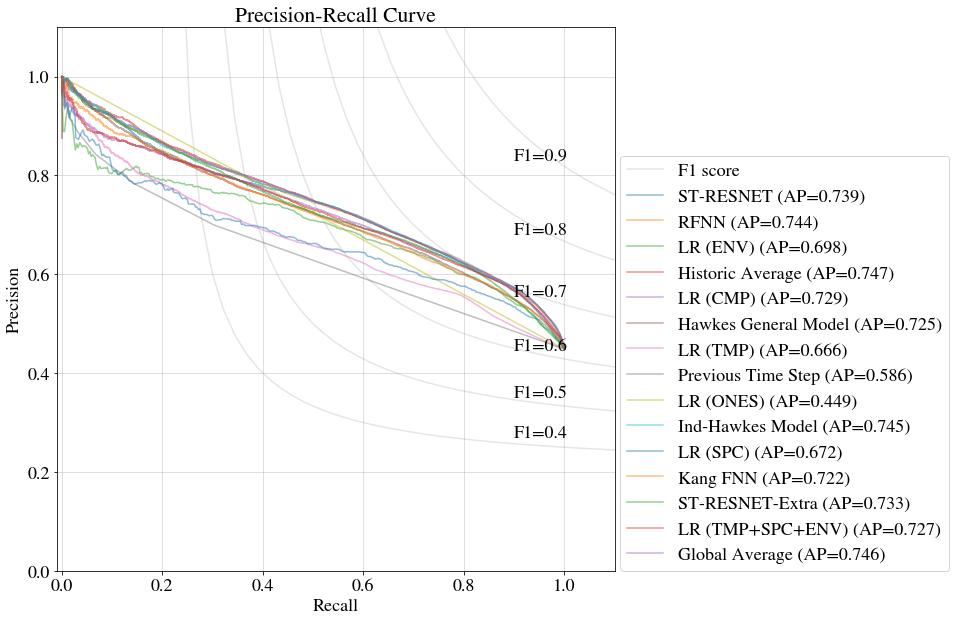

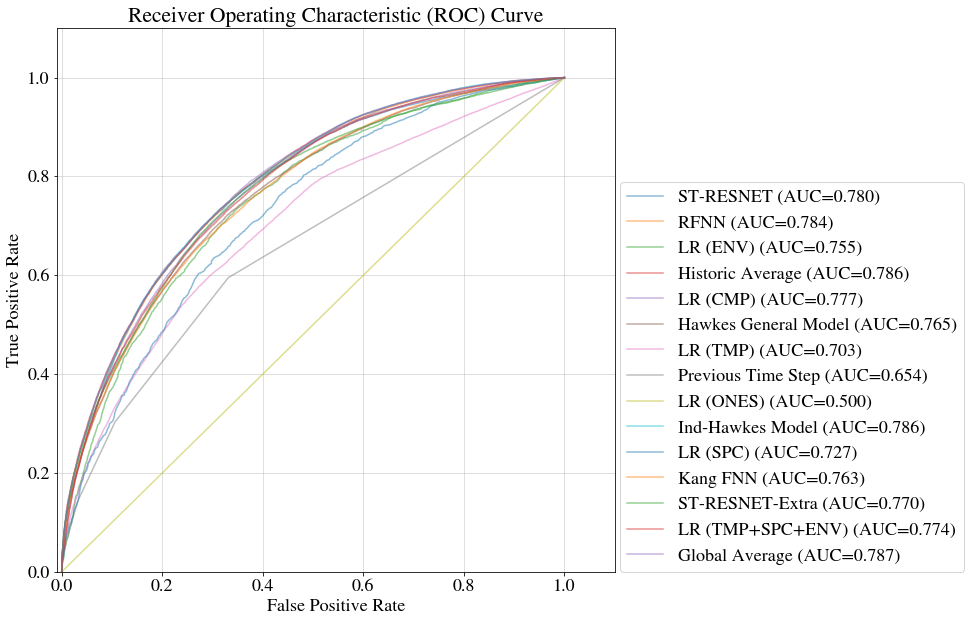

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,
Historic Average,0.785866,0.746661,0.587615,0.873425,0.702565,0.668091,0.395074
Global Average,0.786672,0.745822,0.591271,0.865153,0.702460,0.671070,0.396162
Ind-Hawkes Model,0.785594,0.744993,0.591839,0.859383,0.700949,0.670897,0.393366
RFNN,0.784034,0.743637,0.597967,0.848706,0.701607,0.676005,0.397276
ST-RESNET,0.779583,0.738947,0.573003,0.890193,0.697218,0.652997,0.378949
ST-RESNET-Extra,0.769548,0.733298,0.605537,0.823282,0.697818,0.679991,0.394261
LR (CMP),0.776606,0.728830,0.594392,0.849540,0.699423,0.672293,0.391523
LR (TMP+SPC+ENV),0.774368,0.727405,0.595878,0.842551,0.698064,0.672883,0.389684
Hawkes General Model,0.764797,0.725320,0.583471,0.837485,0.687774,0.658738,0.364316


In [16]:
compare_models(conf.data_path)

2019-11-13T21:50:49 | root | INFO | 
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.785866        0.746661   0.587615  0.873425  0.702565   
Global Average        0.786672        0.745822   0.591271  0.865153  0.702460   
Ind-Hawkes Model      0.785594        0.744993   0.591839  0.859383  0.700949   
RFNN                  0.784034        0.743637   0.597967  0.848706  0.701607   
ST-RESNET             0.779583        0.738947   0.573003  0.890193  0.697218   
ST-RESNET-Extra       0.769548        0.733298   0.605537  0.823282  0.697818   
LR (CMP)              0.776606        0.728830   0.594392  0.849540  0.699423   
LR (TMP+SPC+ENV)      0.774368        0.727405   0.595878  0.842551  0.698064   
Hawkes General Model  0.764797        0.725320   0.583471  0.837485  0.687774   
Kang FNN              0.763432        0.722039   0.580078  0.847809  0.6

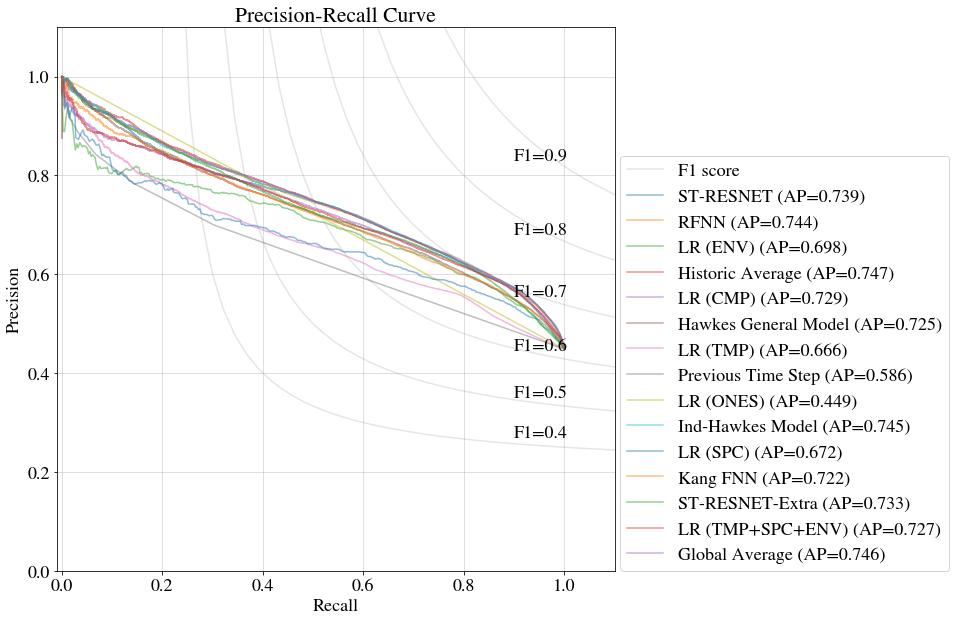

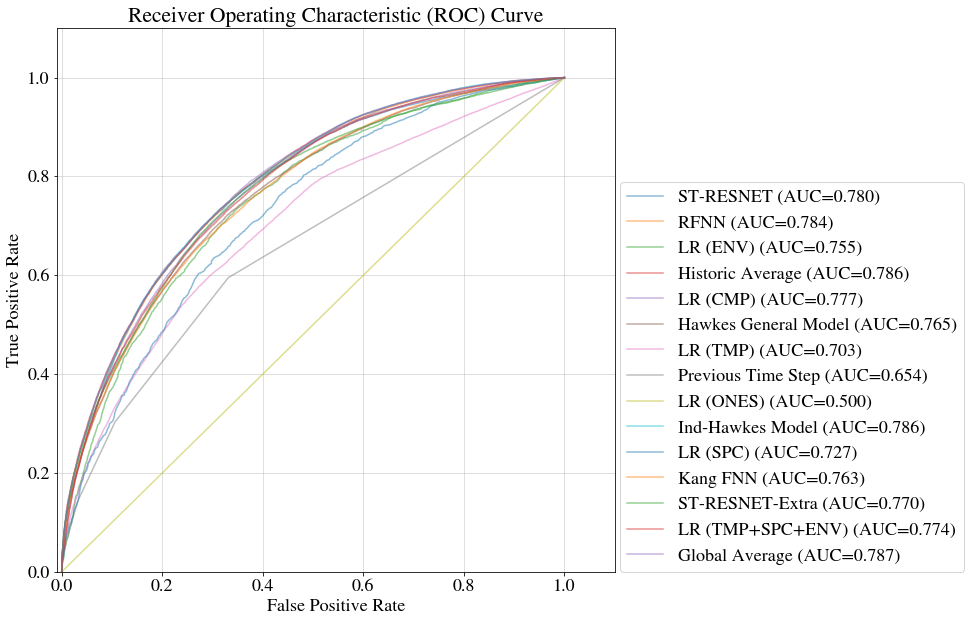

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,
Historic Average,0.785866,0.746661,0.587615,0.873425,0.702565,0.668091,0.395074
Global Average,0.786672,0.745822,0.591271,0.865153,0.702460,0.671070,0.396162
Ind-Hawkes Model,0.785594,0.744993,0.591839,0.859383,0.700949,0.670897,0.393366
RFNN,0.784034,0.743637,0.597967,0.848706,0.701607,0.676005,0.397276
ST-RESNET,0.779583,0.738947,0.573003,0.890193,0.697218,0.652997,0.378949
ST-RESNET-Extra,0.769548,0.733298,0.605537,0.823282,0.697818,0.679991,0.394261
LR (CMP),0.776606,0.728830,0.594392,0.849540,0.699423,0.672293,0.391523
LR (TMP+SPC+ENV),0.774368,0.727405,0.595878,0.842551,0.698064,0.672883,0.389684
Hawkes General Model,0.764797,0.725320,0.583471,0.837485,0.687774,0.658738,0.364316


In [16]:
compare_models(conf.data_path)